#Analytics Lab - Data Engineer Test
# Bryan Camilo Hurtado Suarez

Conexión a google drive donde se ha cargado los datos - solo tener en cuenta si desea realizar conexión a drive

In [2]:
from google.colab import drive
drive.mount('/content/drive') # montar la ruta

Mounted at /content/drive


##Requerimientos

Librerias necesarias para el correcto funcionamiento:

In [3]:
from google.cloud import bigquery         # Conexión a GCP
from google.oauth2 import service_account # Adecuar credenciales de conexión a GCP
import pandas                             # Pandas: para manipulación y análisis de datos
import matplotlib.pyplot as plt           # matplotlib: Realizar Gráficos
import numpy as np                        # manejo de arrays


#machine learning

from sklearn.pipeline  import Pipeline
from sklearn.preprocessing import  StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

## Procedimiento

La base de datos con la que se cuenta contiene información sobre los Homicidios presentados en colombia durante el periodo 2018-01-01 a 2018-12-31, esta es suminustrada por la dirección general de la policía nacional(Dijin).


Ahora se definira el proceso que se seguira para la correcta exploración de los datos:



1.   Conexión a GCP : Enlacazar con Bigquery usandos las credenciales adecuadas. Luego, cargar la bases de datos y verificar la correcta lectura.
2.   Exploración de datos mediante SQL: Analizar la información usando el lenguajes SQL.
3.   Exploración de datos mediante Pandas: Analizar la información usando la libreria Pandas.
4.   Modelo Machine Learning: Selección de un modelo de Machine Learning. Luego, entrenamiento y validación de este.
5.   Arquitectura del modelo: Explicación de la arquitecuta para desarrollar el modelo.
 



## Conexión a GCP Bigquery

En primer lugar, se habilito Bigquery, se realizo la configuración para la correcta comunicación con Bigquery y verficación de que la cuenta usada tenga los accesos correctos, esto mediante "Cloud Shell" de GCP. El procemiento para esto fue el siguiente:



1.   Verificar que el servicio de Bigquery exista, de otro fomra crearlo.
2.   Crear una "service account" y obtener la credenciales que fueron guardadas como "key.json".
3.   Verificar que la cuenta este habilitada como para ser ususario de Bigquery, de otra forma configurarla.



Luego, teniendo configurado el servicio de Bigquery, la credenciales son instanciadas en python mediante la libreria service_account:

In [ ]:
credentials = service_account.Credentials.from_service_account_file('/content/key.json') 

Entonces, se iniaciliza el cliente de Bigquery usando las credenciales ya instanciadas y el ID del proyecto(este es único) ya instanciado:

In [ ]:
client = bigquery.Client(project='sonorous-shore-289314',credentials=credentials)

Ahora, se cuenta con el cliente pero antes de cargarlos a GCP debemos cargarlos a nuestro ambiente de trabajo para lo cual se usa pandas:

In [4]:
homicidios_2018 = pandas.read_excel('/content/drive/My Drive/homicidios-2018.xls') # Carga base de datos

homicidios_2018 = homicidios_2018.drop([12646],axis=0)  # se elimina la última fila que contiene el total

Se conviere a formato CSV para facilitar su carga a Bigquery:

In [ ]:
homicidios_2018.to_csv("homicidios_2018.csv", index=False)

Se realiza el proceso de carga de la siguiente forma:



1.   Creación del dataset
2.   Creación de la tabla dentro del dataset
3.   Configurar el trabajo de carga
4.   Cargar datos

In [ ]:
dataset = client.create_dataset('homicidios_dataset') # crear dataset
table = dataset.table('homicidios_2018_table')  # crear tabla

table_ref = client.dataset("homicidios_dataset").table("homicidios_2018_table") # ruta donde se guardaran los datos

job_config = bigquery.LoadJobConfig()  # Inicalizar el proceso de carga
job_config.source_format = bigquery.SourceFormat.CSV  # formato de carga CSV
job_config.skip_leading_rows = 1 # No tener en cuenta el Header
job_config.autodetect = True # Detectar automaticament el formato de los datos

with open("homicidios_2018.csv", "rb") as source_file: # Abrir archivo - modo lectura y tomado en modo binario
    job = client.load_table_from_file(source_file, table_ref, job_config=job_config)  # cargar datos

job.result() 

En una obsevación preliminar de la infomación se evidencio que el formato original de las columnas "Edad" y "Código Dane" es de texto, esto se soluciona usando el modo automatico de carga que cambia el formato a númerico. En el casos de Pandas debera realizarse manualmente.

Se evidencio que la columna "Profesión" tienen muy pocas entradas y no sera posible tener en cuenta esta variable, estos datos se recojen en campo y no se puede llenar de una manera diferente. De igual forma se evidencia que la columna "cantidad" tiene un error de lógica ya que se presentan en algunos casos 2 o más homicidios pero en un registro(fila) solo se tiene información de una persona, esto debe arreglarse cuando se reunen los datos. 

## Exploración de datos mediante SQL

Para empezar se realiza una consulta sencilla con el fin de evidenciar que las peticiones a Bigquery funcionen correctamente y que el tamaño de los datos cargados sea el adecuado:

In [ ]:
query = """
    SELECT Count(*) as total
    FROM `homicidios_dataset.homicidios_2018_table`
    """
results = client.query(query)
print('Cantidad de datos')
for data in results:
    total= data['total']
    print(f'{total:<20} ')

Cantidad de datos
12646                


Se observa que se tienen 12646 regitros.

Ahora se hace un recuento del total de homicidios presente en la base de datos:

In [ ]:
query = """
    SELECT Sum(Cantidad) as total
    FROM `homicidios_dataset.homicidios_2018_table`
    """
results = client.query(query)
print('Cantidad de homicidios')
for data in results:
    total= data['total']
    print(f'{total:<20} ')

Cantidad de homicidios
12667                


Se presentaron 12667 homicidios en colombia durante el año 2018.

Se selecciona cinco datos simplemente para observar que se cargo correctamente a Bigquery:

In [ ]:
query = """
    SELECT * 
    FROM `homicidios_dataset.homicidios_2018_table`
    LIMIT 5
    """
results = client.query(query)

for data in results:
    print(data)

Row((datetime.date(2018, 4, 11), 'ANTIOQUIA', 'LA CEJA', 'Miércoles', datetime.time(7, 30), 'LA MILAGROSA', 'RURAL', 'FINCAS Y SIMILARES', 'ARMA DE FUEGO', 'A PIE', 'A PIE', '15', 'MASCULINO', 'SOLTERO', 'COLOMBIA', 'INDEPENDIENTE', '-', 'SECUNDARIA', 5376000.0, 1), {'Fecha': 0, 'Departamento': 1, 'Municipio': 2, 'D__a': 3, 'Hora': 4, 'Barrio': 5, 'Zona': 6, 'Clase_de_sitio': 7, 'Arma_empleada': 8, 'M__vil_Agresor': 9, 'M__vil_Victima': 10, 'Edad': 11, 'Sexo': 12, 'Estado_civil': 13, 'Pa__s_de_nacimiento': 14, 'Clase_de_empleado': 15, 'Profesi__n': 16, 'Escolaridad': 17, 'C__digo_DANE': 18, 'Cantidad': 19})
Row((datetime.date(2018, 1, 6), 'ANTIOQUIA', 'CÁCERES', 'Sábado', datetime.time(0, 0), 'EL TIGRE', 'RURAL', 'BARES, CANTINAS Y SIMILARES', 'ARMA DE FUEGO', 'A PIE', 'A PIE', '21', 'MASCULINO', 'SOLTERO', 'COLOMBIA', 'INDEPENDIENTE', '-', 'PRIMARIA', 5120000.0, 1), {'Fecha': 0, 'Departamento': 1, 'Municipio': 2, 'D__a': 3, 'Hora': 4, 'Barrio': 5, 'Zona': 6, 'Clase_de_sitio': 7, 'Arma

Ahora, se empieza e explorar la información más detalladamente. Se hace una consulta para saber en que zona ocurrio la mayor cantidad de homicidios:

In [ ]:
query = """
    SELECT Zona as zona, Sum(Cantidad) as Cantidad
    FROM `homicidios_dataset.homicidios_2018_table`
    GROUP BY zona
    """
results = client.query(query)
print('Zona'.ljust(11),'Homidicios')
for data in results:
    zona= data['zona']
    cantidad= data['Cantidad']
    print(f'{zona:<10} | {cantidad} ')

Zona        Homidicios
RURAL      | 4226 
URBANA     | 8441 


Se observa en que la zona Urbana es la zona más afectada por homicidios durante el año 2018.

Luego, se quiere ver cuales fueron los 10 departamentos con mayor cantidad de homicidios:

In [ ]:
query = """
    SELECT Departamento as departamento, Sum(Cantidad) as Cantidad
    FROM `homicidios_dataset.homicidios_2018_table`
    GROUP BY departamento
    ORDER BY cantidad
    DESC LIMIT 10
    """
results = client.query(query)
print('Departamento'.ljust(21),'Homidicios')
for data in results:
    departamento= data['departamento']
    cantidad= data['Cantidad']
    print(f'{departamento:<20} | {cantidad} ')

Departamento          Homidicios
ANTIOQUIA            | 2449 
VALLE                | 2242 
CUNDINAMARCA         | 1459 
CAUCA                | 688 
NARIÑO               | 643 
ATLÁNTICO            | 548 
NORTE DE SANTANDER   | 522 
BOLÍVAR              | 386 
CÓRDOBA              | 365 
META                 | 274 


Se obtiene que Antioquia, Valle y Cundinamarca son los más afectados presentando más de 1000 homicidios cada uno.

Ahora, se quiere conocer el TOP 10 de municipios respecto a los Homicidios:

In [ ]:
query = """
    SELECT Municipio as municipio, Sum(Cantidad) as Cantidad
    FROM `homicidios_dataset.homicidios_2018_table`
    GROUP BY municipio
    ORDER BY cantidad
    DESC LIMIT 10
    """
results = client.query(query)
print('Municipio'.ljust(21),'Homidicios')
for data in results:
    municipio= data['municipio']
    cantidad= data['Cantidad']
    print(f'{municipio:<20} | {cantidad} ')

Municipio             Homidicios
CALI (CT)            | 1159 
BOGOTÁ D.C. (CT)     | 1064 
MEDELLÍN (CT)        | 626 
BARRANQUILLA (CT)    | 315 
SAN ANDRES DE TUMACO | 249 
CARTAGENA (CT)       | 217 
CÚCUTA (CT)          | 192 
SOACHA               | 158 
PALMIRA              | 156 
CAUCASIA             | 153 


Como se esperaba las grandes ciudades colombianas son las más afectadas, en especial Cali, Bogotá y Medellín.

Se consulta el TOP 10 de sitios donde ocurren homicidios:

In [ ]:
query = """
    SELECT Clase_de_sitio as clase_sitio, Sum(Cantidad) as Cantidad
    FROM `homicidios_dataset.homicidios_2018_table`
    GROUP BY clase_sitio
    ORDER BY cantidad
    DESC LIMIT 10
    """
results = client.query(query)
print('Clase de sitio'.ljust(41),'Homidicios')
for data in results:
    clase_sitio= data['clase_sitio']
    cantidad= data['Cantidad']
    print(f'{clase_sitio:<40} | {cantidad} ')

Clase de sitio                            Homidicios
VIAS PUBLICAS                            | 7699 
FINCAS Y SIMILARES                       | 1352 
CASAS DE HABITACION                      | 750 
CARRETERA                                | 379 
FRENTE A RESIDENCIAS - VIA PUBLICA       | 304 
RIOS                                     | 182 
LOTE BALDIO                              | 181 
BARES, CANTINAS Y SIMILARES              | 172 
DENTRO DE LA VIVIENDA                    | 132 
PARQUES                                  | 79 


Se evidencia que con una gran diferencia es en las Vias públicas donde ocurre la mayor cantidad de homicidios.

Luego, se quiere observar algunas información temporal. En primer lugar se hace un recuento de los homicidios en cada mes:

In [ ]:
query = """
    SELECT EXTRACT(Month from Fecha ) as mes, Sum(Cantidad) as Cantidad
    FROM `homicidios_dataset.homicidios_2018_table`
    GROUP BY mes
    ORDER BY cantidad
    DESC
    """
results = client.query(query)
print('Mes'.ljust(6),'Homidicios')
for data in results:
    mes= data['mes']
    cantidad= data['Cantidad']
    print(f'{mes:<5} | {cantidad} ')

Mes    Homidicios
12    | 1220 
4     | 1119 
1     | 1113 
3     | 1109 
8     | 1079 
7     | 1061 
9     | 1020 
10    | 1014 
5     | 1006 
11    | 994 
6     | 987 
2     | 945 


Se obtuvo que en diciembre es el mes con más asesinatos durante 2018.Luego, se observa el número de homicidios en los diferentes días de la semana:

In [ ]:
query = """
    SELECT D__a as dia, Sum(Cantidad) as Cantidad
    FROM `homicidios_dataset.homicidios_2018_table`
    GROUP BY dia
    ORDER BY cantidad
    DESC 
    """
results = client.query(query)
print('Día'.ljust(16),'Homidicios')
for data in results:
    dia= data['dia']
    cantidad= data['Cantidad']
    print(f'{dia:<15} | {cantidad} ')

Día              Homidicios
Domingo         | 2680 
Sábado          | 2035 
Lunes           | 1832 
Viernes         | 1594 
Miércoles       | 1536 
Martes          | 1506 
Jueves          | 1484 


Como era de esperarse los fines de semana presentaron la mayor cantidad de homicidios. Ahora, se evidencia la cantidad de asesinatos en cada hora:

In [ ]:
query = """
    SELECT EXTRACT(HOUR from Hora ) as hora, Sum(Cantidad) as Cantidad
    FROM `homicidios_dataset.homicidios_2018_table`
    GROUP BY hora
    ORDER BY cantidad
    DESC LIMIT 10
    """
results = client.query(query)
print('Hora'.ljust(6),'Homidicios')
for data in results:
    hora= data['hora']
    cantidad= data['Cantidad']
    print(f'{hora:<5} | {cantidad} ')

Hora   Homidicios
20    | 1044 
21    | 983 
19    | 875 
22    | 711 
23    | 651 
18    | 629 
17    | 565 
0     | 550 
13    | 520 
16    | 494 


Se observa que durante la noche ocurren la mayor cantidad de homicidios como es lógico.

Se explora las armas que ha sido usadas en homicidios:

In [ ]:
query = """
    SELECT Arma_empleada as Arma, Sum(Cantidad) as Cantidad
    FROM `homicidios_dataset.homicidios_2018_table`
    GROUP BY Arma
    ORDER BY cantidad
    DESC
    """
results = client.query(query)
print('Arma'.ljust(36),'Homidicios')
for data in results:
    arma= data['Arma']
    cantidad= data['Cantidad']
    print(f'{arma:<35} | {cantidad} ')

Arma                                 Homidicios
ARMA DE FUEGO                       | 9173 
ARMA BLANCA / CORTOPUNZANTE         | 2768 
CONTUNDENTES                        | 547 
CUERDA/SOGA/CADENA                  | 39 
ARTEFACTO EXPLOSIVO/CARGA DINAMITA  | 39 
BOLSA PLASTICA                      | 23 
CINTAS/CINTURON                     | 14 
MINA ANTIPERSONA                    | 14 
SIN EMPLEO DE ARMAS                 | 11 
COMBUSTIBLE                         | 10 
GRANADA DE MANO                     | 8 
ALMOHADA                            | 7 
ARTEFACTO INCENDIARIO               | 5 
NO REPORTADO                        | 4 
PRENDAS DE VESTIR                   | 2 
QUIMICOS                            | 2 
MOTO BOMBA                          | 1 


Las armas de fuego y cortopunzante son las más usadas para este crimen.

Se observa el empleo de las personas que fueron asesinadas:

In [ ]:
query = """
    SELECT Clase_de_empleado as clase_empleado, Sum(Cantidad) as Cantidad
    FROM `homicidios_dataset.homicidios_2018_table`
    GROUP BY clase_empleado
    ORDER BY cantidad
    DESC 
    """
results = client.query(query)
print('Clase Empleado'.ljust(26),'Homidicios')
for data in results:
    clase_empleado= data['clase_empleado']
    cantidad= data['Cantidad']
    print(f'{clase_empleado:<25} | {cantidad} ')

Clase Empleado             Homidicios
EMPLEADO PARTICULAR       | 4260 
INDEPENDIENTE             | 3912 
DESEMPLEADO               | 2070 
AGRICULTOR                | 860 
COMERCIANTE               | 432 
ESTUDIANTE                | 326 
AMA DE CASA               | 280 
EMPLEADO EJERCITO         | 95 
EMPLEADO POLICIAL         | 81 
DELINCUENCIA              | 69 
PENSIONADO                | 59 
NO REPORTA                | 40 
LIDER CIVICO              | 33 
ETNIA INDIGENA            | 33 
EMPLEADO PUBLICO          | 29 
GRUPOS ILEGALES           | 23 
EDUCADOR                  | 17 
GANADERO                  | 13 
EMPLEADO SALUD            | 11 
EMPLEADO ARMADA/MARINA    | 6 
EMPLEADO INPEC            | 5 
AFRODESCENDIENTE          | 4 
DEPORTISTA                | 4 
EMPLEADO CTI              | 3 
POLITICO                  | 2 


El empleado particular y independiente junto con los desempledos son los más afectados.

## Exploración de datos mediante Pandas

Ahora, se utiliza la libreria Pandas para el manejo y análisis de los datos. En primer lugar, se observan los nombre de las columnas:

In [ ]:
homicidios_2018.columns

Index(['Fecha', 'Departamento', 'Municipio', 'Día', 'Hora', 'Barrio', 'Zona',
       'Clase de sitio', 'Arma empleada', 'Móvil Agresor', 'Móvil Victima',
       'Edad', 'Sexo', 'Estado civil', 'País de nacimiento',
       'Clase de empleado', 'Profesión', 'Escolaridad', 'Código DANE',
       'Cantidad'],
      dtype='object')

Se calcula el tamaño de la base de datos:

In [ ]:
homicidios_2018.shape

(12646, 20)

12646 fila y 20 columnas, se observa las primeras 5 filas y las últimas 5:

In [ ]:
homicidios_2018.head()

,Fecha,Departamento,Municipio,Día,Hora,Barrio,Zona,Clase de sitio,Arma empleada,Móvil Agresor,Móvil Victima,Edad,Sexo,Estado civil,País de nacimiento,Clase de empleado,Profesión,Escolaridad,Código DANE,Cantidad
0,2018-01-01,AMAZONAS,LETICIA (CT),Lunes,09:45:00,ESPERANZA,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,16,MASCULINO,SOLTERO,BRASIL,EMPLEADO PARTICULAR,-,SECUNDARIA,91001000.0,1
1,2018-01-01,AMAZONAS,LETICIA (CT),Lunes,09:45:00,ESPERANZA,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,17,MASCULINO,SOLTERO,BRASIL,EMPLEADO PARTICULAR,-,SECUNDARIA,91001000.0,1
2,2018-01-01,ANTIOQUIA,ANDES,Lunes,08:30:00,ALTO DEL CEDRON,RURAL,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,26,MASCULINO,SOLTERO,COLOMBIA,INDEPENDIENTE,-,PRIMARIA,5034000.0,1
3,2018-01-01,ANTIOQUIA,ANDES,Lunes,02:30:00,PARQUE PRINCIPAL,RURAL,PARQUES,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,30,MASCULINO,SOLTERO,COLOMBIA,AGRICULTOR,-,PRIMARIA,5034000.0,1
4,2018-01-01,ANTIOQUIA,ANORÍ,Lunes,03:30:00,TENCHE,RURAL,"BARES, CANTINAS Y SIMILARES",ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,25,MASCULINO,UNION LIBRE,COLOMBIA,INDEPENDIENTE,-,PRIMARIA,5040000.0,1


In [ ]:
homicidios_2018.tail()

,Fecha,Departamento,Municipio,Día,Hora,Barrio,Zona,Clase de sitio,Arma empleada,Móvil Agresor,Móvil Victima,Edad,Sexo,Estado civil,País de nacimiento,Clase de empleado,Profesión,Escolaridad,Código DANE,Cantidad
12641,2018-12-31,VALLE,CALI (CT),Lunes,16:30:00,PRIMITIVO CRESPO E8,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,20,MASCULINO,SOLTERO,COLOMBIA,INDEPENDIENTE,-,SECUNDARIA,76001000.0,1
12642,2018-12-31,VALLE,CALI (CT),Lunes,21:45:00,ALTO NAPOLES E18,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,24,MASCULINO,SOLTERO,COLOMBIA,DESEMPLEADO,-,SECUNDARIA,76001000.0,1
12643,2018-12-31,VALLE,JAMUNDÍ,Lunes,20:10:00,INVASION LA PLAYITA E24,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,12,MASCULINO,SOLTERO,COLOMBIA,INDEPENDIENTE,-,PRIMARIA,76364000.0,1
12644,2018-12-31,VALLE,PALMIRA,Lunes,09:30:00,CORREGIMIENTO PALMASECA,RURAL,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,17,MASCULINO,SOLTERO,COLOMBIA,INDEPENDIENTE,-,SECUNDARIA,76520000.0,1
12645,2018-12-31,VALLE,TULUÁ,Lunes,03:10:00,La Esperanza,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,16,MASCULINO,SOLTERO,COLOMBIA,ESTUDIANTE,-,SECUNDARIA,76834000.0,1


Se calcula la cantidad de homicidios:

In [5]:
homicidios_2018["Cantidad"].sum()

12667

Se elimina la columna "Código Dane que no sera usado para los análisis:

In [6]:
homicidios_2018=homicidios_2018.drop(['Código DANE'], axis=1)

Se realiza las operaciones para obtener los municipios con mayor cantidad de asesinatos por mes.

En primer lugar, se agrupa por mes y municipio y se calcula cantidad hommicidios:

In [81]:
top=homicidios_2018.groupby(by=[ pandas.DatetimeIndex(homicidios_2018['Fecha']).month,"Municipio"]).sum()

Se seleccionar el Top 3 por mes:

In [82]:
top=top.groupby('Fecha')['Cantidad'].nlargest(3)


In [83]:
top

Fecha  Fecha  Municipio       
1      1      CALI (CT)           106
              BOGOTÁ D.C. (CT)     83
              MEDELLÍN (CT)        56
2      2      BOGOTÁ D.C. (CT)     87
              CALI (CT)            85
              MEDELLÍN (CT)        40
3      3      CALI (CT)           127
              BOGOTÁ D.C. (CT)     93
              MEDELLÍN (CT)        42
4      4      CALI (CT)           118
              BOGOTÁ D.C. (CT)     89
              MEDELLÍN (CT)        57
5      5      CALI (CT)            91
              BOGOTÁ D.C. (CT)     84
              MEDELLÍN (CT)        64
6      6      CALI (CT)            78
              BOGOTÁ D.C. (CT)     70
              MEDELLÍN (CT)        66
7      7      CALI (CT)            95
              BOGOTÁ D.C. (CT)     93
              MEDELLÍN (CT)        54
8      8      CALI (CT)           100
              BOGOTÁ D.C. (CT)     85
              MEDELLÍN (CT)        52
9      9      BOGOTÁ D.C. (CT)    100
              CALI 

Como se habia visto en la explaroción en SQL las ciudades que están en el top todos los meses son Cali, Medellin y Bogotá.

Ahora, para Bogotá se ecuentran los barrios con más homicidios durante 6pm a 12pm:

In [50]:
homicidios_2018['Hora']=pandas.to_datetime(homicidios_2018['Hora'], format='%H:%M:%S')

In [51]:
barrios=homicidios_2018[ (homicidios_2018['Municipio']=='BOGOTÁ D.C. (CT)')  &  (homicidios_2018['Hora'].dt.hour>=18 )]

In [52]:
barrios=barrios.groupby(by=[ "Barrio"]).sum()

In [53]:
barrios=barrios.nlargest(10,'Cantidad')

In [54]:
barrios

,Cantidad
Barrio,
EL PARAISO E-19,7
ARBORIZADORA ALTA E-19,6
CANDELARIA III-IV E-19,6
DIANA TURBAY E-18,5
GRAN BRITALIA E-8,5
CARACOLI E-19,4
JUAN PABLO II E-19,4
LA FAVORITA E-14,4
LA LIBERTAD E-7,4


In [55]:
cantidad=np.concatenate( barrios.values, axis=0 )

Text(0.5, 1.0, 'Top Barrios con más homicidos (Bogotá)')

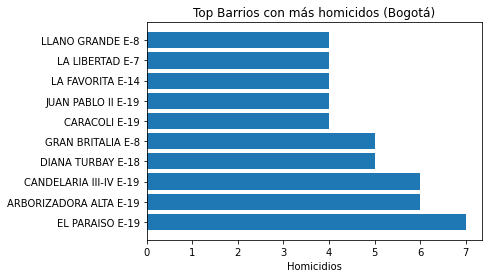

In [56]:
plt.barh(barrios.index.values,cantidad,align='center')
plt.xlabel('Homicidios')

plt.title('Top Barrios con más homicidos (Bogotá)')


Se explora que edad tiene la mayor parte de las victimas:

In [33]:
edad=homicidios_2018.groupby(by=["Edad"]).sum().nlargest(10,'Cantidad')

In [34]:
cantidad=np.concatenate( edad.values, axis=0 )

Text(0.5, 1.0, 'Top edades con más homicidos ')

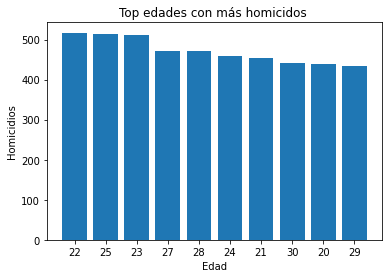

In [37]:
plt.bar(edad.index.values,cantidad,align='center')
plt.xlabel('Edad')
plt.ylabel('Homicidios')

plt.title('Top edades con más homicidos ')

Como se vio en la consulta SQL cali es la ciudad con mayor cantidad de asesinatos, se buscan los barrios más afectados:

In [46]:
barrios=homicidios_2018[ (homicidios_2018['Municipio']=='CALI (CT)') ]

In [47]:
barrios=barrios.groupby(by=[ "Barrio"]).sum().nlargest(10,'Cantidad')

In [48]:
cantidad=np.concatenate( barrios.values, axis=0 )

Text(0.5, 1.0, 'Top Barrios con más homicidos (Cali)')

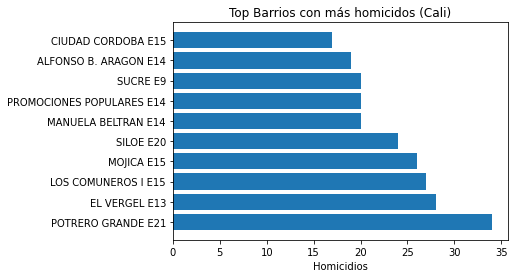

In [49]:
plt.barh(barrios.index.values,cantidad,align='center')
plt.xlabel('Homicidios')

plt.title('Top Barrios con más homicidos (Cali)')


## Modelo de Machine Learning

Decidi utilizar dos modelos de machine learning clasificatorios mediante el uso de regresión logistica, la cual permite clasificar una variable cualitativa en función de varuables cuantitativas y cualitativas(uso one hot encoder). Los modelos son para clasificar la zona en que ocurrio el homicidio y encontrar el arma usada. Estos seran de utilidad para la policia nacional para darles información adicional de cual es la zona y arma más probable durante un homicidio. Después del desarrollo de estos modelos progongo dos modelos a futuro que requeriran un desarrollo más complejo y una mayor cantidad de información.

Modelos implementados: Los modelos  utilizan la variable cuantitativa "Edad" y las variables cualitativas 'Edad','Sexo','Departamento' y 'Clase de sitio' con el fin de prececir la zona y la arma usada. Mediante el uso de regresión logistica.

Proceso:



1.   Ajuste de la columna edad eliminando aquellos registros que no la tienen(23) y convirtiendo su formato a int
2.   Creación de Pipelines para preprocesar las variables de entrada en el caso de la variable cuantitava solamente se le aplicara una normalización estandar y para lo cualitativos se llenaran los campos vacios con "No registra" y se aplicara One Hot Encoder que permite pasar las variables cualitativas a un representación binaria.


Para la normalización de los datos se tiene:

*   Normalizado=(x-media)/(varianza)

De esta forma se tienen los datos con media 0 y desviación estandar de 1.

Se realiza este proceso con el fin de centrar los datos en la misma escala. Esto evitara que existan datos que sean muy grandes comparados con los otros (datos atipicos) que desajusten el modelo.

3. Usar la función "ColumnTransformer" para indicar a que variables se le hara transformación correspondiente y realizar esta.
4. crear Pipelines que tengan anidado el preprocesamiento y se cree el modelo
5. Divir los datos en entrenamiento(70%) y test(30%)
6. Entrenar el modelo (probar solver y elegir el mejor), para esto de adecua los pesos de las clases ya que es un problema desbalanceado
7. Evaluar en los datos de test


Solver seleccionado:

LBFGS se refiere al metodo de quasi-newton. Este calcula la dirección de descenso teniendo en cuenta la matriz Hessiana. En este caso realiza un aproximación de esta, con el fin de reducir el costo computacional y tener una dirección de descenso. En cada iteracción, se mejora esta aproximación, la cual debe ser simétrica y positiva definida.





In [ ]:
homicidios_2018=homicidios_2018.drop( homicidios_2018[homicidios_2018['Edad']=='-'].index,axis=0)

/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [ ]:
homicidios_2018['Edad']= homicidios_2018['Edad'].astype(str).astype(int)

Creación pipelines para preprocesamiento:

In [ ]:
cuantitativa_ajustar = Pipeline(steps=[ ('Scaler', StandardScaler())  ])

In [ ]:
cualitativa_ajustar = Pipeline(steps=[('Simpleimputer', SimpleImputer(strategy='constant',fill_value='No registra')), ('encoder', OneHotEncoder(handle_unknown='ignore'))  ])

Indicar a que columnas se aplicara la transformación y realizarla:

In [ ]:
preprocesamiento = ColumnTransformer(transformers=[('cuantitativa',cuantitativa_ajustar,["Edad"]),  ('cualitativa',cualitativa_ajustar ,[ "Sexo" , "Departamento", "Clase de sitio"])   ])

Definición de modelos lbfgs:

In [316]:
modelo_zona =  Pipeline(steps=[ ('preprocesamiento',preprocesamiento), ('modelo', LogisticRegression(solver='lbfgs',max_iter=1500,class_weight='balanced') )])

modelo_armas = Pipeline(steps=[ ('preprocesamiento',preprocesamiento), ('modelo', LogisticRegression(solver='lbfgs',multi_class='multinomial',max_iter=1500,class_weight='balanced') )])

División de datos:

In [317]:
x_train, x_test, y_train, y_test= train_test_split(homicidios_2018.loc[:,['Edad','Sexo','Departamento','Clase de sitio']], homicidios_2018['Zona'],test_size = 0.30)

Entrenamiento para modelo zona

In [318]:
entrenamiento_modelo_zona=modelo_zona.fit(x_train, y_train)
predecciones=modelo_zona.predict(x_test)
modelo_zona.score(x_test,y_test)

0.820966464219699

Observar resultados:

In [319]:
resultado = pandas.DataFrame(predecciones)

In [320]:
resultado['Cantidad'] = 1

In [321]:
resultado=resultado.groupby(0).count()

In [328]:
resultado

,Cantidad
0,
RURAL,1282
URBANA,2505


In [322]:
original = pandas.DataFrame(y_test)

In [323]:
original['Cantidad'] = 1

In [324]:
original=original.groupby(by=['Zona']).count()

In [325]:
original

,Cantidad
Zona,
RURAL,1238
URBANA,2549


Text(0.5, 1.0, 'Homicidios por zona:predecido')

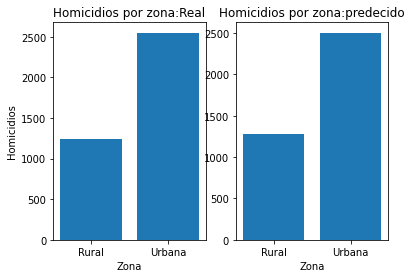

In [327]:
plt.subplot(1,2,1)
plt.bar(['Rural','Urbana'],[original.values[0][0],original.values[1][0]])
plt.ylabel('Homicidios')
plt.xlabel('Zona')
plt.title('Homicidios por zona:Real')

plt.subplot(1,2,2)
plt.bar(['Rural','Urbana'],[resultado.values[0][0],resultado.values[1][0]])
plt.xlabel('Zona')

plt.title('Homicidios por zona:predecido')


Se obtuvo un acierto del 82.06% lo cual es un buen resultado, en busca de mejorarlo se tendria que agregar información como los homicidios en otros años.

División de datos

In [329]:
x_train, x_test, y_train, y_test= train_test_split(homicidios_2018.loc[:,['Edad','Sexo','Departamento','Clase de sitio']], homicidios_2018['Arma empleada'],test_size = 0.20)

Entrenamiento para modelos armas:

In [330]:
entrenamiento_modelo_arma=modelo_armas.fit(x_train, y_train)
predecciones=modelo_armas.predict(x_test)
modelo_armas.score(x_test,y_test)

0.20514851485148514

Revisar Resultados:

In [331]:
resultado = pandas.DataFrame(predecciones)

In [332]:
resultado['Cantidad'] = 1

In [333]:
resultado.groupby(0).count()

,Cantidad
0,
ALMOHADA,51
ARMA BLANCA / CORTOPUNZANTE,414
ARMA DE FUEGO,410
ARTEFACTO EXPLOSIVO/CARGA DINAMITA,221
ARTEFACTO INCENDIARIO,299
BOLSA PLASTICA,279
CINTAS/CINTURON,77
COMBUSTIBLE,76
CONTUNDENTES,157


In [337]:
original = pandas.DataFrame(y_test)

In [338]:
original['Cantidad'] = 1

In [339]:
original.groupby('Arma empleada').count()

,Cantidad
Arma empleada,
ALMOHADA,1
ARMA BLANCA / CORTOPUNZANTE,534
ARMA DE FUEGO,1849
ARTEFACTO EXPLOSIVO/CARGA DINAMITA,12
ARTEFACTO INCENDIARIO,1
BOLSA PLASTICA,4
CINTAS/CINTURON,8
COMBUSTIBLE,3
CONTUNDENTES,101


Se obtuvo un acierto del 20.51% lo cual es malo, para mejorarlo se requiere una mayor cantidad de información debido a que existen armas de las cuales se tienen muy pocos registros y dificulta el desarrollo de un buen modelo.

Modelo a futuro 1: Redes neuronales convolucionales en 1D

El objetivo de este modelo seria decidir si la seguridad de un minicipio es baja-media-alta en un determinado tiempo. Un experto realizaria las etiquetas de cada serie de tiempo y se resolveria como un problema de clasificación.

Se resuelve el problema de clasificación usando una red neuronal, en especifico se realiza una red convolucional. Entonces, las capas convolucionales que se usan son en una dimensión. Estas capas son utiles para que las redes neuronales aprendan caracteristicas secuencias de observaciones. 

Modelo a futuro 2:  Redes neuronales recurrentes

Usar este tipo de modelo para series de tiempo que permite encontrar el futuro estado para asi conocer cual es el estado más probable en el que se encuentre el municipio.

## Arquitectura 

Implementaria una "GCP solution" aprovechando las herramientas y eventajas que ofrece esta plataforma, algunas de estas son:

*   Latencia minima
*   Mayor velocidad de procesamiento
*   Minimas actividades de mantenimiento
*   Escalable facilmente 
*   Obtener resultados de datos en tiempo real

En primer lugar, se haria uso del servicio "Cloud Pub/Sub" que permite agregar datos de diferentes fuentes como bases de datos, dipositivos(computadores, celulares), entre otros. Luego, los datos serian enviados al servicio "Cloud Dataflow" el cual se encargaria del procesamiento (filtrar, transformar). Entonces, estos datos necesitan ser almacenados en un "Data Warehouse" para lo cual se usuaria el servicio "Bigquery" en la cual se podra consultar la información para realizar reportes (gráficos, informes, entre otros).Finalmente, se usuaria el servicio "Cloud ML" para implementar el modelos anteriormete explicado, obteniendo la información de "Bigquery" y enviando la información obtenida del modelo a "Cloud Dataflow" para que se pueda informar de los resultados. Como agregado si se cuenta información de otras fuentes se pueden conectar otros servicios a "Cloud Dataflow" como "Cloud SQL" y "BigTable". De igual forma si se necesita modificar los datos de "Bigquery" estos pueden ser enviados a Cloud Dataflow" donde se transformaran para luego volver a "Bigquery".

## Muchas Gracias por la atención prestada.